# An example of generating playlist by multilable learning w. audio features

In [1]:
%matplotlib inline

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
import hdf5_getters as getters

In [3]:
data_dir = 'data'
faotm = os.path.join(data_dir, 'aotm-2011/aotm-2011-subset.pkl')
fmap  = os.path.join(data_dir, 'aotm-2011/map_song_track.pkl')
msd_h5dir = os.path.join(data_dir, 'msd_h5files')

## Data loading

Load playlists.

In [4]:
playlists_aotm = pkl.load(open(faotm, 'rb'))

In [5]:
print('#Playlists: %d' % len(playlists_aotm))

#Playlists: 241


In [6]:
playlists_aotm[0]

{'category': 'Road Trip',
 'filtered_lists': [['SOYXQBU12CF5F88FAA',
   'SOYDNDN12A58A77663',
   'SOOLDQA12A6D4F9370',
   'SOHCPBA12AB018377B',
   'SOHGHSU12AB0186C5F',
   'SOFRCHU12A8C13F96B',
   'SONHAWL12A6310F260',
   'SOXRJWV12A8C13DE1D',
   'SOUPNVN12AB018B0B4',
   'SOEYNQL12A67ADE655',
   'SOZTMFN12A58A7DCEE',
   'SORDYVO12A8C141A40']],
 'mix_id': 113009,
 'playlist': [[['Simon & Garfunkel', 'America'], 'SOYXQBU12CF5F88FAA'],
  [['Marc Cohn', 'Walking In Memphis'], 'SOYDNDN12A58A77663'],
  [['Matt Pond PA', 'Lily Two'], 'SOOLDQA12A6D4F9370'],
  [['Grateful Dead', 'Tennessee Jed'], 'SOHCPBA12AB018377B'],
  [['Braid', 'Killing a Camera'], 'SOHGHSU12AB0186C5F'],
  [['Johnny Cash', 'Hey Porter'], 'SOFRCHU12A8C13F96B'],
  [["Marcy's Playground", 'Memphis'], 'SONHAWL12A6310F260'],
  [['Whiskeytown', 'Lo-Fi Tennessee Mountain Angel'], 'SOXRJWV12A8C13DE1D'],
  [['Something Corporate', 'I Woke Up in a Car'], 'SOUPNVN12AB018B0B4'],
  [['The Boy Least Likely To',
    "I'm Glad I Hitched My

In [7]:
song_set = sorted({songID for p in playlists_aotm for songID in p['filtered_lists'][0]})

In [8]:
print('#Songs: %d' % len(song_set))

#Songs: 1718


In [9]:
lengths = [len(p['filtered_lists'][0]) for p in playlists_aotm]
#plt.hist(lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(lengths))

Average playlist length: 9.2


`Song_id --> Song_name` mapping.

In [10]:
songID2Name = {s[1]: s[0] for p in playlists_aotm for s in p['playlist']}

Load `song_id` --> `track_id` mapping: a song may correspond to multiple tracks.

In [11]:
song2TrackID = pkl.load(open(fmap, 'rb'))

In [12]:
{ k : song2TrackID[k] for k in list(song2TrackID.keys())[:10] }

{'SOBJBEU12AF729D526': ['TRFLJNE12903CB44F1'],
 'SOBLXOO12A58A7870A': ['TRABRUJ128F42ADE0D'],
 'SOJFGXT12AB0186D31': ['TRPUVGG12903CD6A5A'],
 'SOJVQWN12AB0187D69': ['TRZWLVV128F9340EF3'],
 'SOLZXJE12A8C133B6E': ['TRBJRDR128F92F3510'],
 'SOMIPXY12A67ADE66D': ['TRLGPPQ128F426B1E9'],
 'SOMKIVW12A6D4F7CDB': ['TRZJGZK128E0793FA4'],
 'SONUPZD12A8C13981F': ['TRDEGWP128F426DD48'],
 'SOOEAYQ12CF5F86D5D': ['TRKYOVQ128F4298956'],
 'SOTTEQB12AB0184AA3': ['TRIDAJL128F9324505']}

## Load audio features

Load the audio features given `songID`, if a song has more than one `trackID`, simply use the first available track.

In [13]:
def load_features(songID, msd_h5dir = msd_h5dir, song2TrackID = song2TrackID):
    assert(songID in song2TrackID)
    trackIDs = song2TrackID[songID]
    for trackID in trackIDs:
        h5f = os.path.join(msd_h5dir, trackID + '.h5')
        if os.path.exists(h5f): 
            h5 = getters.open_h5_file_read(h5f)
            
            segpits = getters.get_segments_pitches(h5)
            segtimbs = getters.get_segments_timbre(h5)
            assert(segpits.shape == segtimbs.shape)

            # possibly different first dimension for different tracks, simply take the mean
            m = segpits.shape[1]
            features = np.sum(segpits, axis = 0) / m + np.sum(segtimbs, axis = 0) / m 

            h5.close()
            return features
        
    # no track available
    return None

In [14]:
#ffeatures = os.path.join(data_dir, 'features.pkl')
song2Feature = dict()
for songID in song_set:
    features = load_features(songID)
    assert(features is not None)
    song2Feature[songID] = features

In [15]:
#song2Feature

In [16]:
# save to features to file
# load features

In [17]:
def gen_features(songID, song2Feature = song2Feature):
    assert(songID in song2Feature)
    return song2Feature[songID]

In [18]:
def gen_feature_map(song_id, seed):
    """
        Generate feature mapping for a given (label, query) pair
    """
    
    #return gen_features(song_id) - gen_features(seed)  # feature map
    return gen_features(seed)  # a trivial feature map

In [19]:
def gen_training_set(label_ix, playlists = playlists_aotm, song_set = song_set):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - label_ix: song index, number in { 0, ..., # songs }
            - playlists: which playlists to create features for
            
        Output:
            - (Feature, Label) pair (X, y), with # num playlists rows
              X comprises the features for each seed song and the given song
              y comprises the indicator of whether the given song is present in the respective playlist
    """

    assert(label_ix >= 0)
    assert(label_ix < len(song_set))
    
    _feature = gen_feature_map(song_set[0], playlists[0]['filtered_lists'][0][0])

    N = len(playlists)
    d = _feature.shape[0]

    X = np.zeros((N, d), dtype = np.float)
    y = np.zeros(N, dtype = np.float)
    
    whichSong = song_set[label_ix]
    
    for i in range(len(playlists)):
        playlist = playlists[i]['filtered_lists'][0]
        seed     = playlist[0]

        X[i,:] = gen_feature_map(whichSong, seed)
        y[i]   = int(whichSong in playlist)

    return X, y

In [20]:
gen_feature_map(song_set[0], playlists_aotm[0]['filtered_lists'][0][0])

array([ 1870.8585    ,   417.34866667,  -900.51725   , -1263.148     ,
       -1194.73758333,  -669.576     ,  -422.739     ,  -622.09241667,
         404.70966667,     8.75233333,     6.93216667,  1148.1455    ])

## Training & Testing

Train a logistic regression model for each label.

In [21]:
classifiers = [LogisticRegression(class_weight='balanced') for i in range(len(song_set))]

In [22]:
allPreds  = [ ]
allTruths = [ ]
coefMat = [ ]
labelIndices = [ ]

#sample_ix = np.random.choice(np.arange(len(playlists_aotm)), 100)
#playlists = [playlists_aotm[ix] for ix in sample_ix]
playlists = playlists_aotm

Y = np.NAN * np.ones((len(playlists), len(song_set)))

for label_ix in range(len(song_set)):
    sys.stdout.write('\r%d / %d' % (label_ix+1, len(song_set)))
    sys.stdout.flush()    
    
    X, y = gen_training_set(label_ix, playlists=playlists)
    Y[:, label_ix] = y
    scaler = StandardScaler(copy=False)
    X = scaler.fit_transform(X)    
    
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, \
                                                                           test_size = 0.33, \
                                                                           random_state = 31)    
    
    if np.max(y_train) == 0.0: # or np.max(y_test) == 0.0:
        continue

    classifiers[label_ix].fit(X_train, y_train)
    
    allPreds.append(classifiers[label_ix].decision_function(X_test))
    allTruths.append(y_test)    

    coefMat.append(classifiers[label_ix].coef_.reshape(-1))
    labelIndices.append(label_ix)
    #print(classifiers[label_ix].coef_)
    #print(classifiers[label_ix].intercept_)

1718 / 1718

In [23]:
allPreds = np.array(allPreds).T
allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(80, 1273)
(80, 1273)


## Evaluation

Compute AUC.

Average AUC: 0.6542


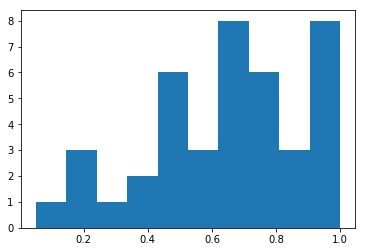

In [24]:
aucs = [ ]
for i in range(0,allPreds.shape[0]):
    pred  = allPreds[i,:]
    truth = allTruths[i,:]
    
    if np.max(truth) == 0.0:
        continue
    
    aucs.append(sk.metrics.roc_auc_score(truth, pred))
    
print('Average AUC: %1.4f' % np.mean(aucs))
plt.hist(aucs, bins = 10);

Compute average precision.

## Result analysis

Coefficient matrix `(#Genres, #Songs)`.

In [25]:
coefMat = np.array(coefMat).T

In [26]:
coefMat.shape

(12, 1273)